# Imports

In [10]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt


This part under takes the data set from MNIST with all the numbers and labels for what the numbers should be and spilts it up into:
figs = the image and its data
figsValue = what the image should be labeled as 

Text(0.5, 1.0, 'Number is 4')

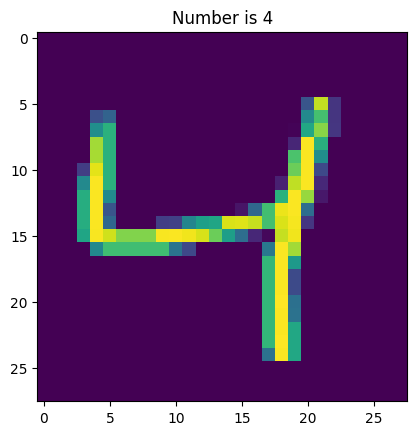

In [20]:
figs, figsValue = torch.load("C:\\Users\\caker\\GitHubRepos\\neuralNet\\DataMNIST\\processed\\training.pt")

plt.imshow(figs[2].numpy())
plt.title(f'Number is {figsValue[2].numpy()}')


Now we take the `figsValue` and turn it into a 10 dimensional vector (because there are numbers 0-9 in the data set) and make it have 1 for the label its supposed to display
e.g figValue[1] = "4" => figValue[1] = "0000100000"
we do this with a "one hot encoder" whatever that is


In [15]:
figsValue = F.one_hot(figsValue,num_classes=10)
figsValue.shape

torch.Size([60000, 10])

So now we have to deal with the `figs` becasue currentally this is 6000 28x28 matrix's (i think) but it'd be nicer if it was 6000 784 dimiensional vectors (28^2). So we change that now 

In [16]:
figs.view(-1,28**2).shape

torch.Size([60000, 784])

Ok now we know how to setup the data so that we can train it now we will make it easier to train. 

Okay now we have to make an dataset object so its easier to train (i think).Some points here to notice are:
- The CTDataset class has a inheritance relationship with the Dataset class of torch.utils.data
- The `figs` data is loaded and then normilized because the pixels are form 0-255 (which indiactes brightness) to now between 0-1
- The `figs` data is not into a 784 dimesinol vector yet (because we want to be able to plot these images)
- You have to overide some of these functions so that we can use some methods on this object later (len,getitem)
- also notice that a image and label is returned(a tuple i beleive) from the getitem so thats usefull

In [22]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.figs, self.figsValue = torch.load(filepath)
        self.figs = self.figs / 255.
        self.figsValue = F.one_hot(self.figsValue, num_classes=10).to(float)
    def __len__(self): 
        return self.figs.shape[0]
    def __getitem__(self, ix): 
        return self.figs[ix], self.figsValue[ix]

Now we spilt it into two different data sets (80/20 rule) but I think this data set is accutally a bit different. 

In [23]:
trainDS = CTDataset("C:\\Users\\caker\\GitHubRepos\\neuralNet\\DataMNIST\\processed\\training.pt")
testDS = CTDataset("C:\\Users\\caker\\GitHubRepos\\neuralNet\\DataMNIST\\processed\\test.pt")

In [24]:
# testing to see how it works
len(trainDS)

60000

Cool now what we need to is to wrap this Dataset with a dataloader in order to control batch size (no idea why that matters) 

We can then put the Dataset objects inside a DataLoader class. This is useful because we can specify a batch_size. Each iteration through the dataloader will yield a tensor where the first dimension is equal to the batch_size.

In [25]:
train_dl = DataLoader(trainDS, batch_size=5)

In [26]:
# how that is working
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 10])


In [27]:
len(train_dl) #because it has batches of 5 x 12000 = 60 000

12000

# Cross Entropy Loss 
- using it without understanding 
- i know it has something to do with how the weights of the neural network change and we need to minimize this fucntion 

In [36]:
L = nn.CrossEntropyLoss()

# The network
- I guess this must be the standard archticture of a NN  

Questions I have are:
- what is this nn.Module inherantice relationship
- why do we change the image data here and not in the `CTDataset` object
- dont know what `squeeze` or `view` does
-  

In [29]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()
netWork = MyNeuralNet()

In [33]:
# feeding the NN without any training 
xs,ys =trainDS[0:4] # the image(xs) and its value(ys)
netWork(xs)

tensor([[-0.0294,  0.1563,  0.0133, -0.0803, -0.1249, -0.0145, -0.1033,  0.1490,
          0.1580,  0.0136],
        [-0.0318,  0.1188,  0.0183, -0.0868, -0.1122,  0.0064, -0.1136,  0.1415,
          0.1808,  0.0436],
        [-0.0629,  0.1074, -0.0237, -0.0700, -0.1274, -0.0143, -0.1173,  0.1297,
          0.1508,  0.0465],
        [-0.0377,  0.1155, -0.0468, -0.1141, -0.1058, -0.0075, -0.0996,  0.1081,
          0.1311,  0.0420]], grad_fn=<SqueezeBackward0>)

Curently the network is not tuned so its just spiting out random values which are coming from the network (idk how) eveneuatly these two should line up

In [34]:
ys

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

Stochastic gradient decesent to minimize the cross entropy loss function!

"We want these predictions f(xs) to match the ys for all images. For these to match, the loss function L(f(xs), ys) should be as small as possible. As such, we adjust the weights of f such that L becomes as small as possible. This is done below:"

- So right now our loss is below  (2.3296) and we want to get this number close to 0
- Below is one part of the iteration of the training prosces 

In [37]:
L(netWork(xs),ys)

tensor(2.3296, dtype=torch.float64, grad_fn=<DivBackward1>)

# Training
- what is a epoch ? (goes through the entire dataset once (i.e 60 000))
- what does `enumerate` do (okay it seems like this is kinda like a Iterator object in java and it just keeps track of numbers of iterations)

In [38]:
def train_model(dataLoader, netWork, n_epochs=20):
    # Optimization
    opt = SGD(netWork.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dataLoader) # length of the data loader 
        for i, (x, y) in enumerate(dataLoader):
            # Update the weights of the network
            opt.zero_grad() 
            loss_value = L(netWork(x), y) 
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [39]:
# Now training it
epoch_data, loss_data = train_model(train_dl, netWork)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy (per batch)')

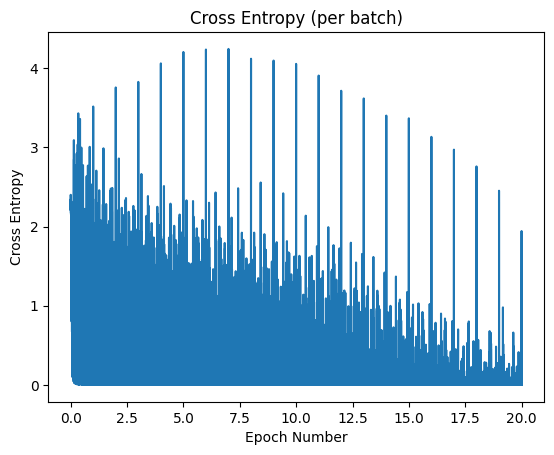

In [40]:
# A plot of the loss function for every batch (batch_size = 5)
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (per batch)')

0.0015833333333333333


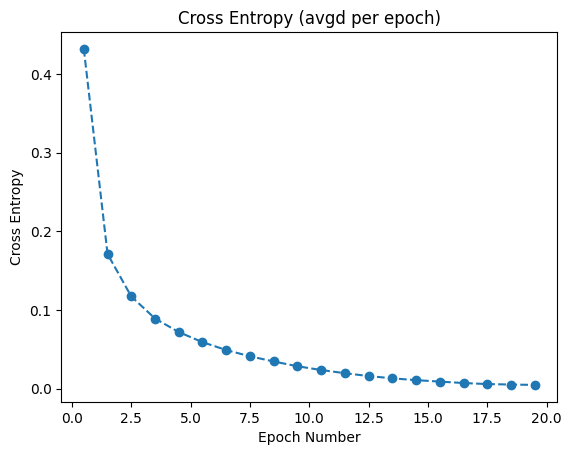

In [42]:
# now the average version
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

print(epoch_data[19])

pretty cool the model is now trained lets see a little test run

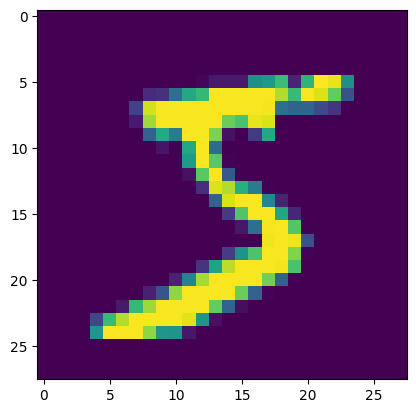

In [49]:
sample5 = trainDS[0][0]
plt.imshow(sample5) # is the number 5 

So we have a 5 lets see what the model predicts it to be (with the network now being trained)

In [54]:
prediction = netWork(sample5)

print(prediction) # the not normilized preditction
torch.argmax(prediction) # the normilized preditction

tensor([ -6.4316,   1.2485,  -1.9968,  25.9152, -31.3891,  30.8704, -11.5109,
        -10.5378,  -2.4535,   5.6984], grad_fn=<SqueezeBackward0>)


tensor(5)

WOWWWWW thast cool it got it interesting that the next most likely number is a 3.

# Test
Okay so now we have to test the model now that it is all done being trained (using the test dataset)

In [87]:
# TO GET ACCURACY 
iterations = 0 
for img, newImgValue in testDS: # for each img and newImgValue in testDS do the follwing
    if torch.argmax(netWork(img)) == torch.argmax(newImgValue): # if the prediction is the same as the accuatly result
        iterations+=1
        
print("Acuuracy is = %f%%" % (iterations/len(testDS)*100))



Acuuracy is = 97.530000%


NOW ALL DONE and we have a accyraacy of 97.530% which is pretty darn good. 